# Fine-Tuning Diffusion Models: LoRA and Beyond
## Klein Base 4B - Architecture, Methods, and Practical Insights

This workshop goes beyond the basics. We assume you:
- Understand what LoRA is and have used it before
- Know how to read training curves
- Are familiar with diffusion models

**What we'll actually cover:**
1. Flow matching vs DDPM — why Klein Base trains differently
2. Klein architecture deep dive — double vs single stream blocks
3. Parameter-efficient methods compared — LoRA, DoRA, LoKr, full fine-tune
4. Layer-wise analysis — which layers encode what
5. LoRA composition and merging
6. Text encoder vs transformer fine-tuning

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
from matplotlib.gridspec import GridSpec

plt.style.use('dark_background')
plt.rcParams.update({'figure.figsize': (14, 6), 'font.size': 11})

# Consistent colors
C = {
    'frozen': '#4a5568',
    'lora': '#e53e3e', 
    'dora': '#9333ea',
    'lokr': '#f59e0b',
    'full': '#3b82f6',
    'good': '#22c55e',
    'warn': '#eab308',
    'info': '#38bdf8',
    'double': '#8b5cf6',
    'single': '#06b6d4',
}

print("Ready")

Ready


---
# Part 1: Flow Matching — Why Klein Base is Different

Most LoRA tutorials assume DDPM (noise prediction). Klein Base uses **flow matching** (velocity prediction).

This isn't just an implementation detail — it affects:
- Loss weighting across timesteps
- How gradients flow during training
- What the model is actually learning

Let's visualize the difference.

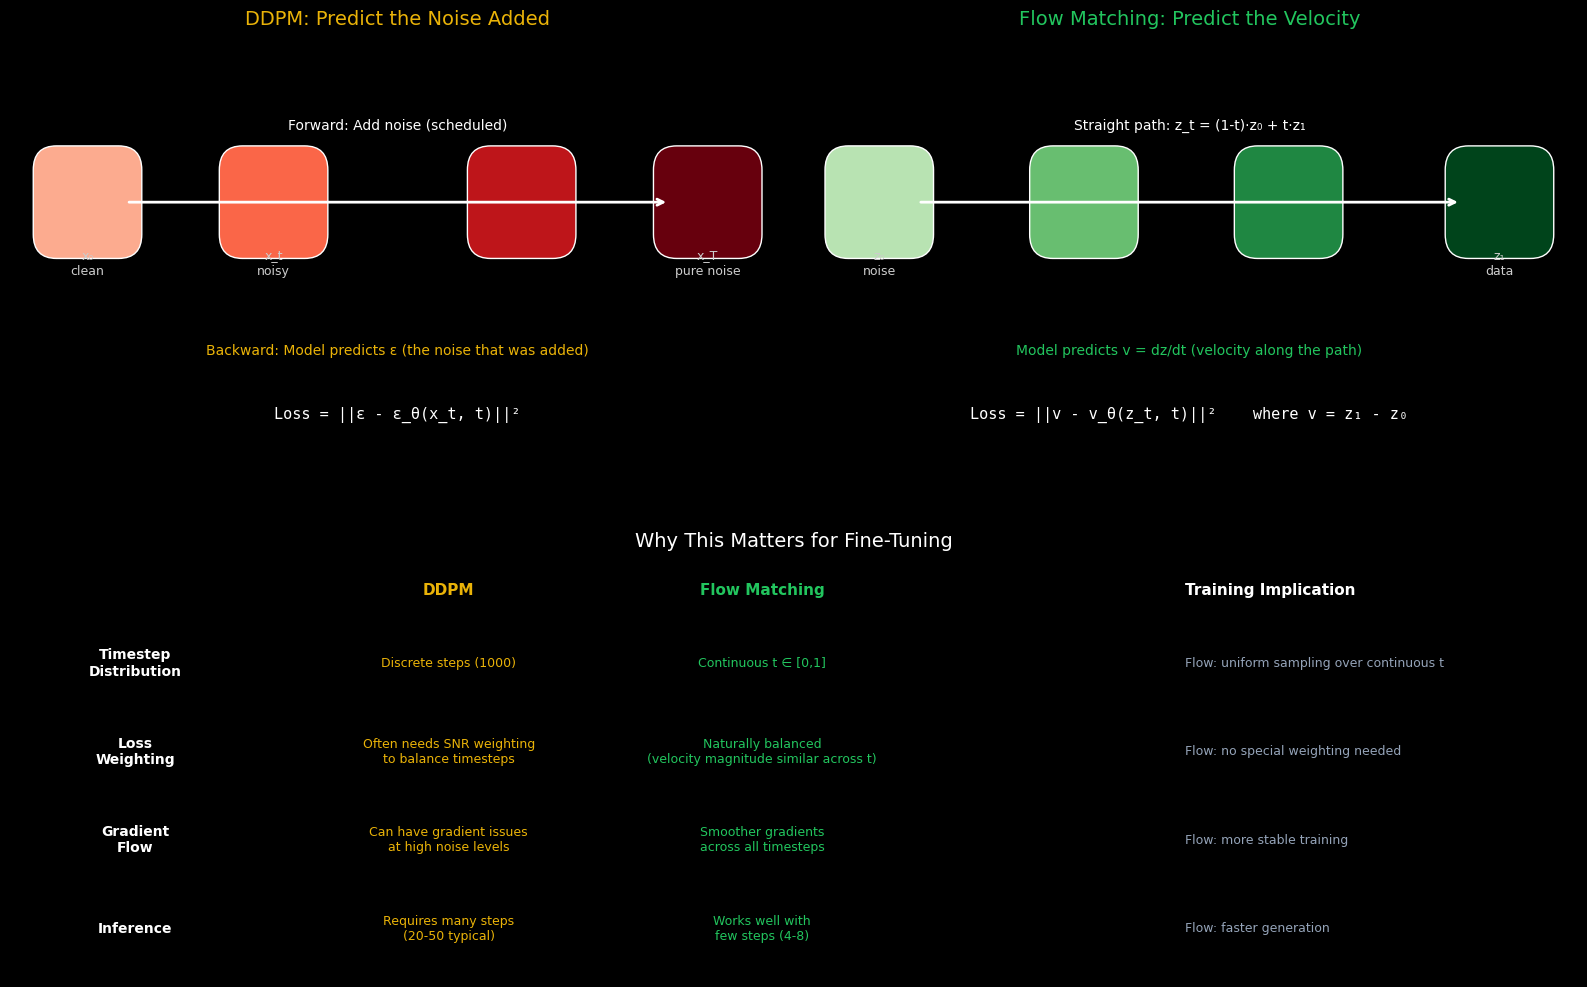

In [2]:
def compare_ddpm_vs_flow():
    """Compare DDPM and flow matching training paradigms."""
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(2, 2, figure=fig, height_ratios=[1.2, 1])
    
    # === Top left: DDPM process ===
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 6)
    ax1.axis('off')
    ax1.set_title('DDPM: Predict the Noise Added', fontsize=14, color=C['warn'])
    
    # DDPM forward: x_0 -> x_t
    for i, (t, label) in enumerate([(0, 'x₀\nclean'), (0.3, 'x_t\nnoisy'), (0.7, ''), (1.0, 'x_T\npure noise')]):
        x = 1 + t * 8
        noise_level = t
        color = plt.cm.Reds(0.3 + 0.7 * t)
        ax1.add_patch(FancyBboxPatch((x-0.4, 3.5), 0.8, 0.8, boxstyle="round",
                                      facecolor=color, edgecolor='white', linewidth=1))
        if label:
            ax1.text(x, 3, label, ha='center', fontsize=9, color='#ccc')
    
    ax1.annotate('', xy=(8.5, 3.9), xytext=(1.5, 3.9),
                arrowprops=dict(arrowstyle='->', color='white', lw=2))
    ax1.text(5, 4.8, 'Forward: Add noise (scheduled)', ha='center', fontsize=10, color='white')
    
    # DDPM backward
    ax1.text(5, 2, 'Backward: Model predicts ε (the noise that was added)', 
            ha='center', fontsize=10, color=C['warn'])
    ax1.text(5, 1.2, 'Loss = ||ε - ε_θ(x_t, t)||²', ha='center', fontsize=11, 
            family='monospace', color='white')
    
    # === Top right: Flow matching process ===
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.set_xlim(0, 10)
    ax2.set_ylim(0, 6)
    ax2.axis('off')
    ax2.set_title('Flow Matching: Predict the Velocity', fontsize=14, color=C['good'])
    
    # Flow: straight line from noise to data
    for i, (t, label) in enumerate([(0, 'z₀\nnoise'), (0.33, ''), (0.66, ''), (1.0, 'z₁\ndata')]):
        x = 1 + t * 8
        color = plt.cm.Greens(0.3 + 0.7 * t)
        ax2.add_patch(FancyBboxPatch((x-0.4, 3.5), 0.8, 0.8, boxstyle="round",
                                      facecolor=color, edgecolor='white', linewidth=1))
        if label:
            ax2.text(x, 3, label, ha='center', fontsize=9, color='#ccc')
    
    ax2.annotate('', xy=(8.5, 3.9), xytext=(1.5, 3.9),
                arrowprops=dict(arrowstyle='->', color='white', lw=2))
    ax2.text(5, 4.8, 'Straight path: z_t = (1-t)·z₀ + t·z₁', ha='center', fontsize=10, color='white')
    
    # Flow backward
    ax2.text(5, 2, 'Model predicts v = dz/dt (velocity along the path)', 
            ha='center', fontsize=10, color=C['good'])
    ax2.text(5, 1.2, 'Loss = ||v - v_θ(z_t, t)||²    where v = z₁ - z₀', 
            ha='center', fontsize=11, family='monospace', color='white')
    
    # === Bottom: Practical implications ===
    ax3 = fig.add_subplot(gs[1, :])
    ax3.axis('off')
    ax3.set_title('Why This Matters for Fine-Tuning', fontsize=14, pad=20)
    
    comparisons = [
        ('Timestep\nDistribution', 
         'Discrete steps (1000)',
         'Continuous t ∈ [0,1]',
         'Flow: uniform sampling over continuous t'),
        ('Loss\nWeighting',
         'Often needs SNR weighting\nto balance timesteps',
         'Naturally balanced\n(velocity magnitude similar across t)',
         'Flow: no special weighting needed'),
        ('Gradient\nFlow',
         'Can have gradient issues\nat high noise levels',
         'Smoother gradients\nacross all timesteps',
         'Flow: more stable training'),
        ('Inference',
         'Requires many steps\n(20-50 typical)',
         'Works well with\nfew steps (4-8)',
         'Flow: faster generation'),
    ]
    
    for i, (aspect, ddpm, flow, implication) in enumerate(comparisons):
        y = 0.78 - i * 0.22
        ax3.text(0.08, y, aspect, ha='center', va='center', fontsize=10, 
                fontweight='bold', color='white', transform=ax3.transAxes)
        ax3.text(0.28, y, ddpm, ha='center', va='center', fontsize=9, 
                color=C['warn'], transform=ax3.transAxes)
        ax3.text(0.48, y, flow, ha='center', va='center', fontsize=9, 
                color=C['good'], transform=ax3.transAxes)
        ax3.text(0.75, y, implication, ha='left', va='center', fontsize=9, 
                color='#94a3b8', transform=ax3.transAxes)
    
    # Header
    ax3.text(0.28, 0.95, 'DDPM', ha='center', fontsize=11, fontweight='bold', 
            color=C['warn'], transform=ax3.transAxes)
    ax3.text(0.48, 0.95, 'Flow Matching', ha='center', fontsize=11, fontweight='bold', 
            color=C['good'], transform=ax3.transAxes)
    ax3.text(0.75, 0.95, 'Training Implication', ha='left', fontsize=11, fontweight='bold', 
            color='white', transform=ax3.transAxes)
    
    plt.tight_layout()
    plt.show()

compare_ddpm_vs_flow()

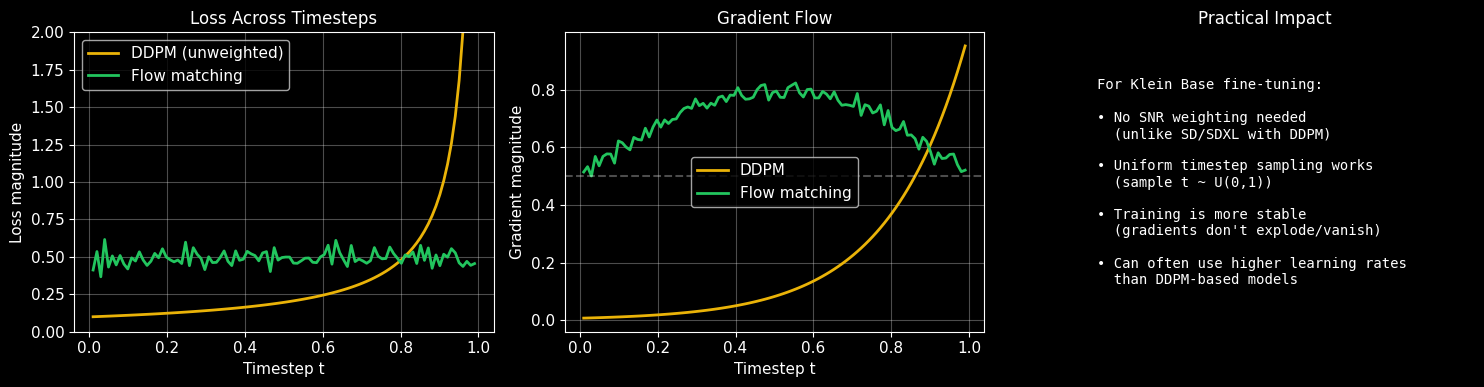

In [3]:
def show_loss_landscape_difference():
    """Visualize how loss behaves across timesteps in both paradigms."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    t = np.linspace(0.01, 0.99, 100)
    
    # === Panel 1: Raw loss magnitude ===
    ax1 = axes[0]
    # DDPM: loss varies wildly with timestep
    ddpm_loss = 1 / (1 - t + 0.01) * 0.1  # Higher at high t (more noise)
    # Flow: more uniform
    flow_loss = np.ones_like(t) * 0.5 + np.random.randn(100) * 0.05
    
    ax1.plot(t, ddpm_loss, color=C['warn'], lw=2, label='DDPM (unweighted)')
    ax1.plot(t, flow_loss, color=C['good'], lw=2, label='Flow matching')
    ax1.set_xlabel('Timestep t')
    ax1.set_ylabel('Loss magnitude')
    ax1.set_title('Loss Across Timesteps', fontsize=12)
    ax1.legend()
    ax1.set_ylim(0, 2)
    ax1.grid(True, alpha=0.3)
    
    # === Panel 2: Gradient magnitude ===
    ax2 = axes[1]
    ddpm_grad = np.exp(-5 * (1 - t))  # Vanishing at low t
    flow_grad = 0.5 + 0.3 * np.sin(t * np.pi) + np.random.randn(100) * 0.02
    
    ax2.plot(t, ddpm_grad, color=C['warn'], lw=2, label='DDPM')
    ax2.plot(t, flow_grad, color=C['good'], lw=2, label='Flow matching')
    ax2.set_xlabel('Timestep t')
    ax2.set_ylabel('Gradient magnitude')
    ax2.set_title('Gradient Flow', fontsize=12)
    ax2.legend()
    ax2.axhline(0.5, color='white', ls='--', alpha=0.3)
    ax2.grid(True, alpha=0.3)
    
    # === Panel 3: What this means ===
    ax3 = axes[2]
    ax3.axis('off')
    ax3.set_title('Practical Impact', fontsize=12)
    
    text = """
For Klein Base fine-tuning:

• No SNR weighting needed
  (unlike SD/SDXL with DDPM)

• Uniform timestep sampling works
  (sample t ~ U(0,1))

• Training is more stable
  (gradients don't explode/vanish)

• Can often use higher learning rates
  than DDPM-based models
"""
    ax3.text(0.1, 0.9, text, transform=ax3.transAxes, fontsize=10, 
            color='white', verticalalignment='top', family='monospace')
    
    plt.tight_layout()
    plt.show()

show_loss_landscape_difference()

---
# Part 2: Klein Base Architecture

Klein Base uses a **dual-stream transformer** with two distinct block types:

- **Double-stream blocks** (5 blocks): Process image and text separately, then cross-attend
- **Single-stream blocks** (20 blocks): Process concatenated image+text jointly

Where you apply LoRA matters.

TypeError: _AxesBase.add_patch() got an unexpected keyword argument 'facecolor'

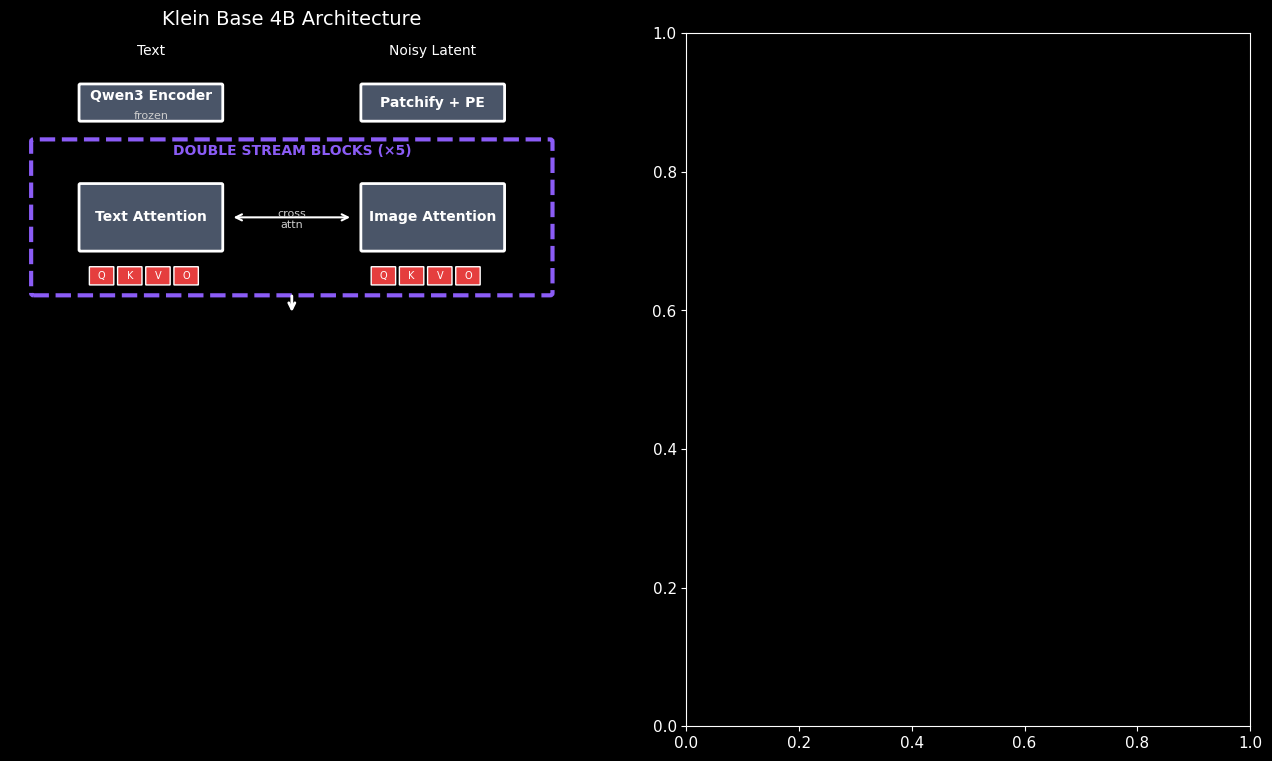

In [10]:
def show_klein_architecture_detail():
    """Detailed view of Klein Base 4B architecture."""
    fig, axes = plt.subplots(1, 2, figsize=(16, 9))
    
    # === Left: Overall architecture ===
    ax1 = axes[0]
    ax1.set_xlim(0, 12)
    ax1.set_ylim(0, 16)
    ax1.axis('off')
    ax1.set_title('Klein Base 4B Architecture', fontsize=14)
    
    def box(x, y, w, h, label, color, sublabel=None, lw=2):
        ax1.add_patch(FancyBboxPatch((x, y), w, h, boxstyle="round,pad=0.03",
                                      facecolor=color, edgecolor='white', linewidth=lw))
        ax1.text(x + w/2, y + h/2 + (0.15 if sublabel else 0), label, 
                ha='center', va='center', fontsize=10, color='white', fontweight='bold')
        if sublabel:
            ax1.text(x + w/2, y + h/2 - 0.3, sublabel, ha='center', va='center', 
                    fontsize=8, color='#ccc')
    
    # Inputs
    ax1.text(3, 15.5, 'Text', ha='center', fontsize=10, color='white')
    ax1.text(9, 15.5, 'Noisy Latent', ha='center', fontsize=10, color='white')
    
    # Encoders
    box(1.5, 14, 3, 0.8, 'Qwen3 Encoder', C['frozen'], 'frozen')
    box(7.5, 14, 3, 0.8, 'Patchify + PE', C['frozen'])
    
    # Double stream blocks
    ax1.add_patch(FancyBboxPatch((0.5, 10), 11, 3.5, boxstyle="round,pad=0.05",
                                  facecolor='none', edgecolor=C['double'], linewidth=3, linestyle='--'))
    ax1.text(6, 13.2, 'DOUBLE STREAM BLOCKS (×5)', ha='center', fontsize=10, 
            color=C['double'], fontweight='bold')
    
    box(1.5, 11, 3, 1.5, 'Text Attention', C['frozen'])
    box(7.5, 11, 3, 1.5, 'Image Attention', C['frozen'])
    ax1.annotate('', xy=(7.3, 11.75), xytext=(4.7, 11.75),
                arrowprops=dict(arrowstyle='<->', color='white', lw=1.5))
    ax1.text(6, 11.5, 'cross\nattn', ha='center', fontsize=8, color='#ccc')
    
    # Show LoRA locations in double stream
    for x_base in [1.7, 7.7]:
        for i, l in enumerate(['Q', 'K', 'V', 'O']):
            ax1.add_patch(FancyBboxPatch((x_base + i*0.6, 10.2), 0.5, 0.4, boxstyle="round,pad=0.01",
                                          facecolor=C['lora'], edgecolor='white', linewidth=1))
            ax1.text(x_base + i*0.6 + 0.25, 10.4, l, ha='center', va='center', fontsize=7, color='white')
    
    # Arrow down
    ax1.annotate('', xy=(6, 9.5), xytext=(6, 10),
                arrowprops=dict(arrowstyle='->', color='white', lw=2))
    
    # Single stream blocks
    ax1.add_patch(FancyBboxPatch((2, 3), 8, 6), boxstyle="round,pad=0.05",
                                  facecolor='none', edgecolor=C['single'], linewidth=3, linestyle='--')
    ax1.text(6, 8.7, 'SINGLE STREAM BLOCKS (×20)', ha='center', fontsize=10, 
            color=C['single'], fontweight='bold')
    
    box(3, 5.5, 6, 2, 'Joint Self-Attention', C['frozen'], 'concatenated img+txt')
    
    # LoRA locations in single stream
    for i, l in enumerate(['Q', 'K', 'V', 'O', 'MLP']):
        w = 0.7 if l != 'MLP' else 1.0
        ax1.add_patch(FancyBboxPatch((3.3 + i*1.1, 5.7), w, 0.5, boxstyle="round,pad=0.01",
                                      facecolor=C['lora'], edgecolor='white', linewidth=1))
        ax1.text(3.3 + i*1.1 + w/2, 5.95, l, ha='center', va='center', fontsize=8, color='white')
    
    box(3, 3.5, 6, 1.2, 'FFN / MLP', C['frozen'])
    
    # Output
    ax1.annotate('', xy=(6, 2.5), xytext=(6, 3),
                arrowprops=dict(arrowstyle='->', color='white', lw=2))
    box(3, 1.5, 6, 0.8, 'Unpatchify', C['frozen'])
    ax1.text(6, 0.8, 'Predicted velocity v', ha='center', fontsize=10, color='white')
    
    # Legend
    ax1.add_patch(FancyBboxPatch((0.3, 0.3), 0.4, 0.3, facecolor=C['lora'], edgecolor='white'))
    ax1.text(0.9, 0.45, 'LoRA targets', fontsize=9, color='white', va='center')
    
    # === Right: Parameter counts ===
    ax2 = axes[1]
    ax2.set_title('Parameter Distribution', fontsize=14)
    
    components = ['Double Stream\nAttention', 'Single Stream\nAttention', 'Single Stream\nMLP',
                  'Embeddings', 'Other']
    params = [0.4, 1.6, 1.2, 0.6, 0.2]  # In billions (approximate)
    colors = [C['double'], C['single'], C['info'], C['frozen'], C['frozen']]
    
    bars = ax2.barh(components, params, color=colors, edgecolor='white', linewidth=2)
    ax2.set_xlabel('Parameters (Billions)')
    
    for bar, p in zip(bars, params):
        ax2.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2, 
                f'{p}B', va='center', fontsize=10)
    
    ax2.set_xlim(0, 2.2)
    
    # Add annotation
    ax2.text(0.5, -0.15, 
            'Most parameters are in single-stream blocks.\n'
            'But double-stream blocks handle critical text↔image interaction.',
            transform=ax2.transAxes, ha='center', fontsize=10, color='#94a3b8')
    
    plt.tight_layout()
    plt.show()

show_klein_architecture_detail()

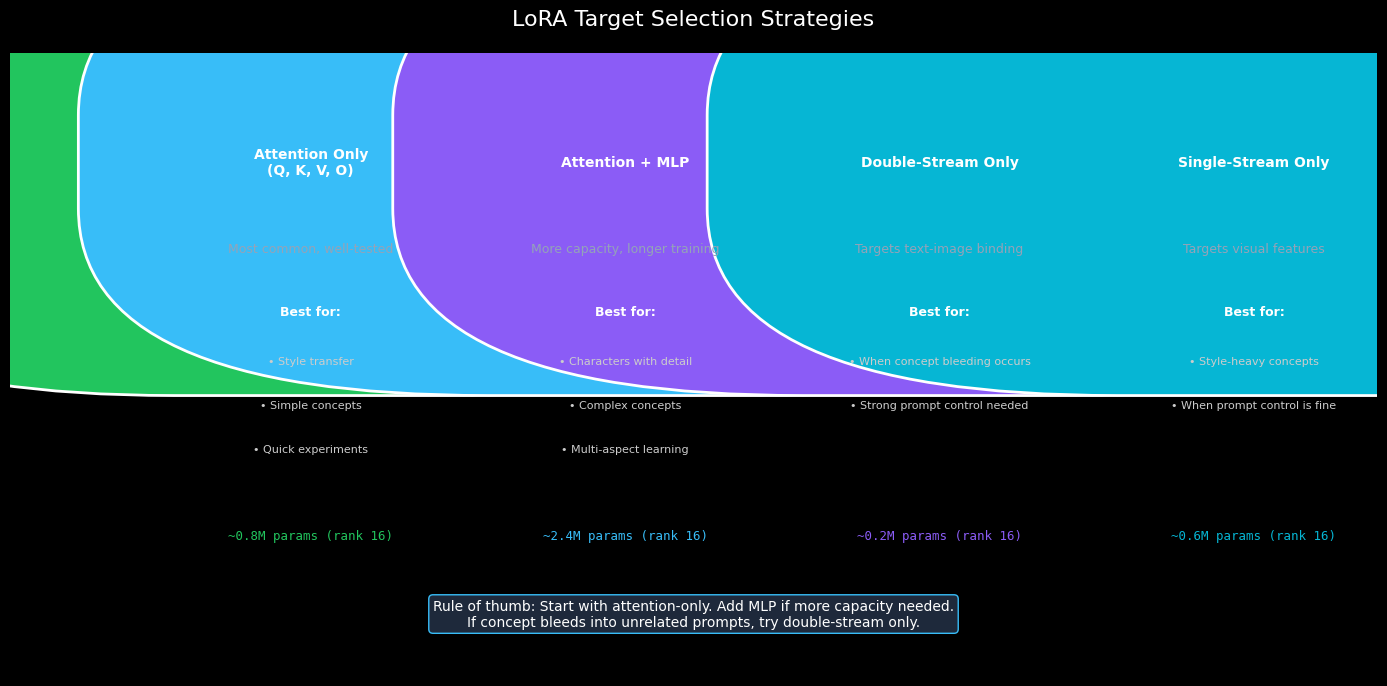

In [11]:
def compare_lora_targets():
    """Compare different LoRA targeting strategies."""
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.axis('off')
    ax.set_title('LoRA Target Selection Strategies', fontsize=16, pad=20)
    
    strategies = [
        ('Attention Only\n(Q, K, V, O)',
         'Most common, well-tested',
         ['Style transfer', 'Simple concepts', 'Quick experiments'],
         '~0.8M params (rank 16)',
         C['good']),
        ('Attention + MLP',
         'More capacity, longer training',
         ['Characters with detail', 'Complex concepts', 'Multi-aspect learning'],
         '~2.4M params (rank 16)',
         C['info']),
        ('Double-Stream Only',
         'Targets text-image binding',
         ['When concept bleeding occurs', 'Strong prompt control needed'],
         '~0.2M params (rank 16)',
         C['double']),
        ('Single-Stream Only',
         'Targets visual features',
         ['Style-heavy concepts', 'When prompt control is fine'],
         '~0.6M params (rank 16)',
         C['single']),
    ]
    
    for i, (name, desc, use_cases, params, color) in enumerate(strategies):
        x = 0.12 + i * 0.23
        
        # Header box
        ax.add_patch(FancyBboxPatch((x, 0.75), 0.2, 0.15, boxstyle="round",
                                     facecolor=color, edgecolor='white', linewidth=2,
                                     transform=ax.transAxes))
        ax.text(x + 0.1, 0.825, name, ha='center', va='center', fontsize=10,
               fontweight='bold', color='white', transform=ax.transAxes)
        
        # Description
        ax.text(x + 0.1, 0.68, desc, ha='center', fontsize=9, color='#94a3b8',
               transform=ax.transAxes)
        
        # Use cases
        ax.text(x + 0.1, 0.58, 'Best for:', ha='center', fontsize=9, 
               fontweight='bold', color='white', transform=ax.transAxes)
        for j, uc in enumerate(use_cases):
            ax.text(x + 0.1, 0.50 - j*0.07, f'• {uc}', ha='center', fontsize=8,
                   color='#ccc', transform=ax.transAxes)
        
        # Params
        ax.text(x + 0.1, 0.22, params, ha='center', fontsize=9, color=color,
               family='monospace', transform=ax.transAxes)
    
    # Bottom note
    ax.text(0.5, 0.08, 
           'Rule of thumb: Start with attention-only. Add MLP if more capacity needed.\n'
           'If concept bleeds into unrelated prompts, try double-stream only.',
           ha='center', fontsize=10, color='white', transform=ax.transAxes,
           bbox=dict(boxstyle='round', facecolor='#1e293b', edgecolor=C['info']))
    
    plt.tight_layout()
    plt.show()

compare_lora_targets()

---
# Part 3: Beyond LoRA — PEFT Methods Compared

LoRA isn't the only game in town. Let's compare:

- **LoRA**: Low-rank decomposition (A × B)
- **DoRA**: LoRA with magnitude/direction decomposition
- **LoKr**: Kronecker product decomposition
- **Full fine-tuning**: No tricks, just update everything

Each has different trade-offs.

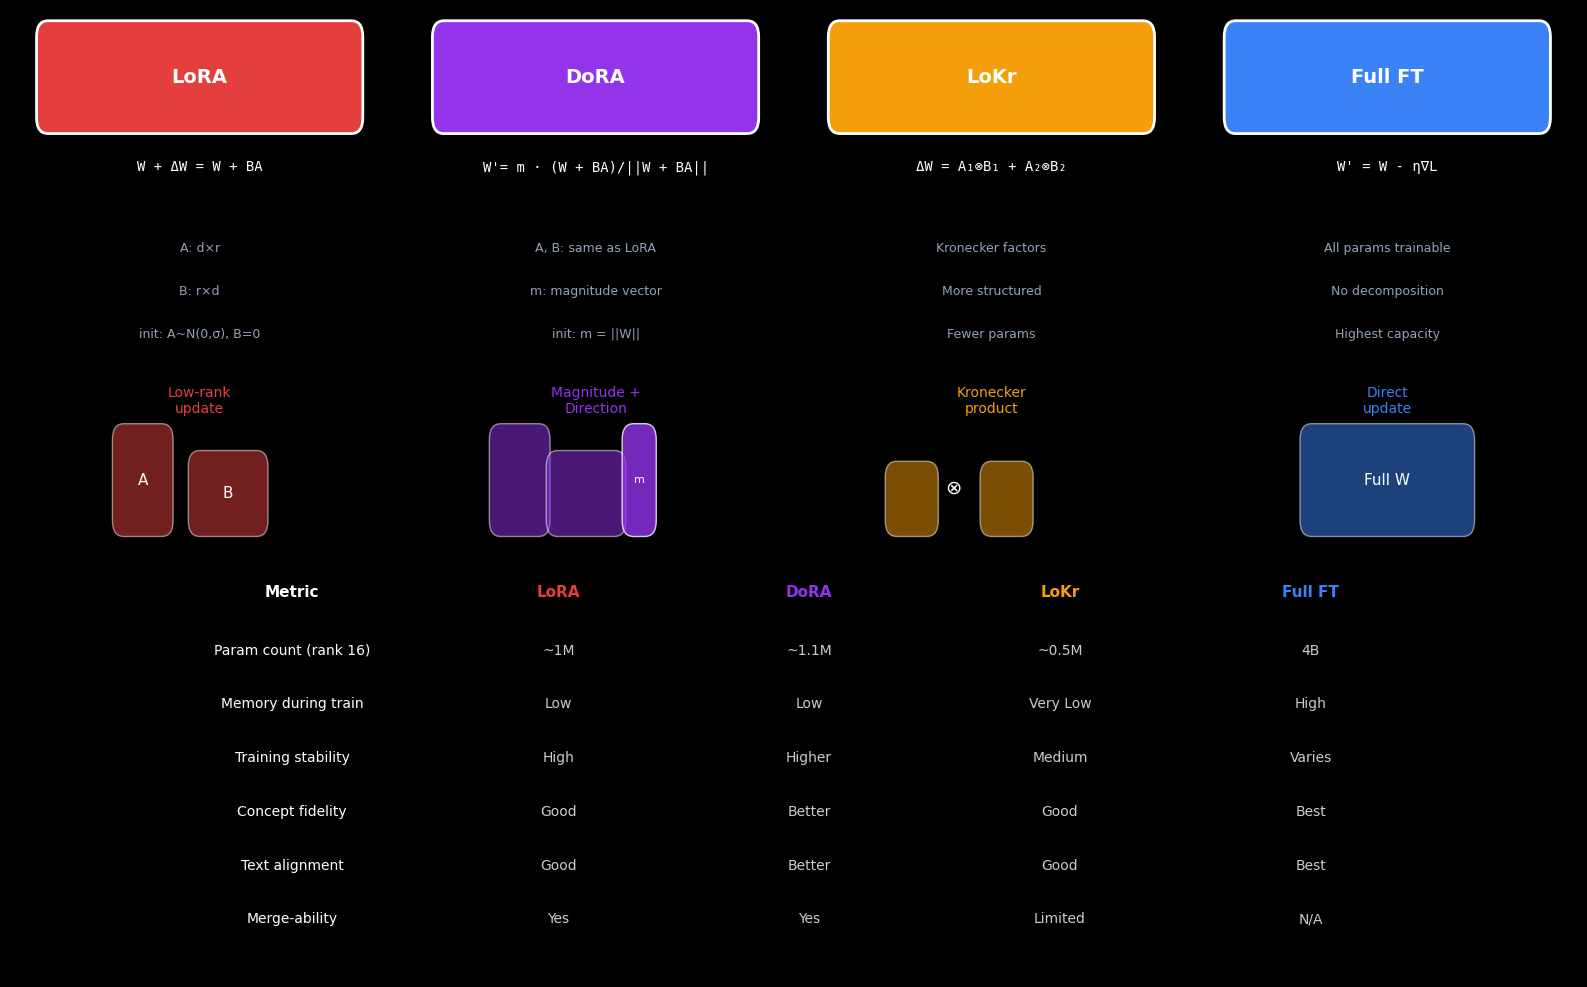

In [12]:
def compare_peft_methods():
    """Visual comparison of PEFT methods."""
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(2, 4, figure=fig, height_ratios=[1.3, 1])
    
    methods = [
        ('LoRA', C['lora'], 
         'W + ΔW = W + BA',
         ['A: d×r', 'B: r×d', 'init: A~N(0,σ), B=0'],
         'Low-rank\nupdate'),
        ('DoRA', C['dora'],
         'W\'= m · (W + BA)/||W + BA||',
         ['A, B: same as LoRA', 'm: magnitude vector', 'init: m = ||W||'],
         'Magnitude +\nDirection'),
        ('LoKr', C['lokr'],
         'ΔW = A₁⊗B₁ + A₂⊗B₂',
         ['Kronecker factors', 'More structured', 'Fewer params'],
         'Kronecker\nproduct'),
        ('Full FT', C['full'],
         'W\' = W - η∇L',
         ['All params trainable', 'No decomposition', 'Highest capacity'],
         'Direct\nupdate'),
    ]
    
    # Top row: method details
    for i, (name, color, formula, details, viz_label) in enumerate(methods):
        ax = fig.add_subplot(gs[0, i])
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 10)
        ax.axis('off')
        
        # Title
        ax.add_patch(FancyBboxPatch((1, 8), 8, 1.5, boxstyle="round",
                                     facecolor=color, edgecolor='white', linewidth=2))
        ax.text(5, 8.75, name, ha='center', va='center', fontsize=14, 
               fontweight='bold', color='white')
        
        # Formula
        ax.text(5, 7, formula, ha='center', fontsize=10, family='monospace', color='white')
        
        # Details
        for j, d in enumerate(details):
            ax.text(5, 5.5 - j*0.8, d, ha='center', fontsize=9, color='#94a3b8')
        
        # Visual representation
        ax.text(5, 2.5, viz_label, ha='center', fontsize=10, color=color)
        
        # Simple matrix viz
        if name == 'LoRA':
            ax.add_patch(FancyBboxPatch((3, 0.5), 1, 1.5, facecolor=color, alpha=0.5))
            ax.text(3.5, 1.25, 'A', ha='center', va='center', color='white')
            ax.add_patch(FancyBboxPatch((5, 0.5), 1.5, 1, facecolor=color, alpha=0.5))
            ax.text(5.75, 1, 'B', ha='center', va='center', color='white')
        elif name == 'DoRA':
            ax.add_patch(FancyBboxPatch((2.5, 0.5), 1, 1.5, facecolor=color, alpha=0.5))
            ax.add_patch(FancyBboxPatch((4, 0.5), 1.5, 1, facecolor=color, alpha=0.5))
            ax.add_patch(FancyBboxPatch((6, 0.5), 0.3, 1.5, facecolor=color, alpha=0.8))
            ax.text(6.15, 1.25, 'm', ha='center', va='center', color='white', fontsize=8)
        elif name == 'LoKr':
            ax.add_patch(FancyBboxPatch((2.5, 0.5), 0.8, 0.8, facecolor=color, alpha=0.5))
            ax.text(4, 1, '⊗', ha='center', color='white', fontsize=14)
            ax.add_patch(FancyBboxPatch((5, 0.5), 0.8, 0.8, facecolor=color, alpha=0.5))
        else:
            ax.add_patch(FancyBboxPatch((3, 0.5), 4, 1.5, facecolor=color, alpha=0.5))
            ax.text(5, 1.25, 'Full W', ha='center', va='center', color='white')
    
    # Bottom: comparison table
    ax_table = fig.add_subplot(gs[1, :])
    ax_table.axis('off')
    
    metrics = [
        ('Param count (rank 16)', '~1M', '~1.1M', '~0.5M', '4B'),
        ('Memory during train', 'Low', 'Low', 'Very Low', 'High'),
        ('Training stability', 'High', 'Higher', 'Medium', 'Varies'),
        ('Concept fidelity', 'Good', 'Better', 'Good', 'Best'),
        ('Text alignment', 'Good', 'Better', 'Good', 'Best'),
        ('Merge-ability', 'Yes', 'Yes', 'Limited', 'N/A'),
    ]
    
    colors_row = [C['lora'], C['dora'], C['lokr'], C['full']]
    
    # Headers
    ax_table.text(0.18, 0.92, 'Metric', ha='center', fontsize=11, fontweight='bold', 
                 color='white', transform=ax_table.transAxes)
    for i, (name, color) in enumerate(zip(['LoRA', 'DoRA', 'LoKr', 'Full FT'], colors_row)):
        ax_table.text(0.35 + i*0.16, 0.92, name, ha='center', fontsize=11, 
                     fontweight='bold', color=color, transform=ax_table.transAxes)
    
    for j, (metric, *values) in enumerate(metrics):
        y = 0.78 - j * 0.13
        ax_table.text(0.18, y, metric, ha='center', fontsize=10, color='white',
                     transform=ax_table.transAxes)
        for i, (val, color) in enumerate(zip(values, colors_row)):
            ax_table.text(0.35 + i*0.16, y, val, ha='center', fontsize=10, 
                         color='#ccc', transform=ax_table.transAxes)
    
    plt.tight_layout()
    plt.show()

compare_peft_methods()

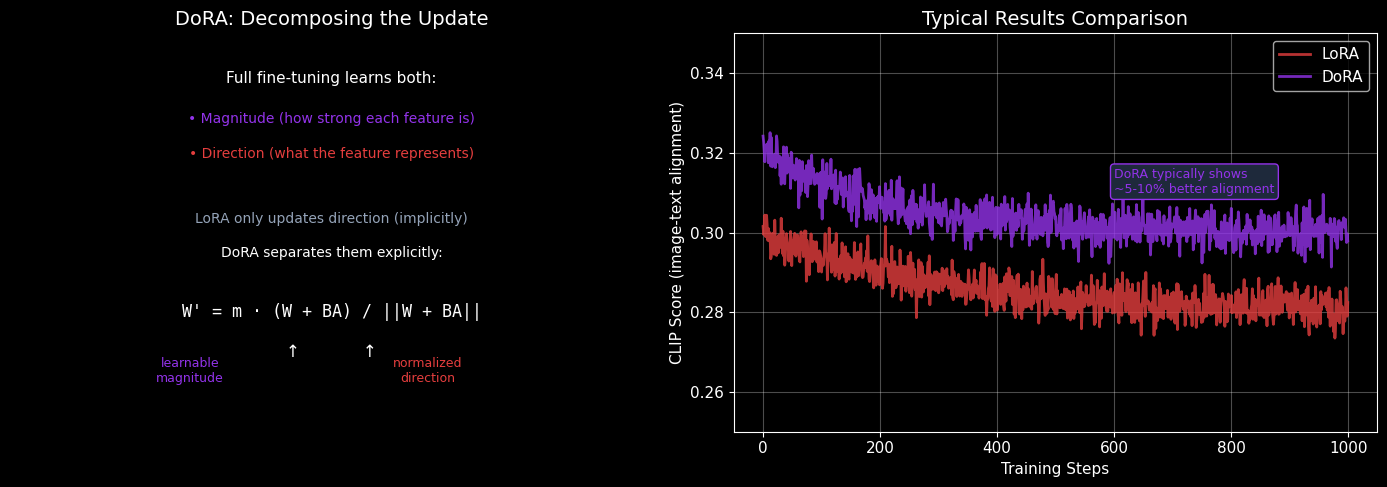

When to use DoRA over LoRA:
• When text-image alignment is critical
• When you're seeing 'concept drift' with LoRA
• When you have compute budget for slightly longer training


In [13]:
def explain_dora_advantage():
    """Why DoRA often works better than LoRA."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # === Left: The decomposition ===
    ax1 = axes[0]
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 8)
    ax1.axis('off')
    ax1.set_title('DoRA: Decomposing the Update', fontsize=14)
    
    # Show the decomposition
    ax1.text(5, 7, 'Full fine-tuning learns both:', ha='center', fontsize=11, color='white')
    ax1.text(5, 6.2, '• Magnitude (how strong each feature is)', ha='center', fontsize=10, color=C['dora'])
    ax1.text(5, 5.5, '• Direction (what the feature represents)', ha='center', fontsize=10, color=C['lora'])
    
    ax1.text(5, 4.2, 'LoRA only updates direction (implicitly)', ha='center', fontsize=10, color='#94a3b8')
    ax1.text(5, 3.5, 'DoRA separates them explicitly:', ha='center', fontsize=10, color='white')
    
    # Formula
    ax1.text(5, 2.3, "W' = m · (W + BA) / ||W + BA||", ha='center', fontsize=12, 
            family='monospace', color='white')
    ax1.text(5, 1.5, '↑            ↑', ha='center', fontsize=12, color='white')
    ax1.text(2.8, 1.0, 'learnable\nmagnitude', ha='center', fontsize=9, color=C['dora'])
    ax1.text(6.5, 1.0, 'normalized\ndirection', ha='center', fontsize=9, color=C['lora'])
    
    # === Right: Empirical result ===
    ax2 = axes[1]
    ax2.set_title('Typical Results Comparison', fontsize=14)
    
    np.random.seed(42)
    steps = np.arange(1000)
    
    # Simulated training curves
    lora_clip = 0.28 + 0.02 * np.exp(-steps/300) + np.random.randn(1000)*0.003
    dora_clip = 0.30 + 0.02 * np.exp(-steps/200) + np.random.randn(1000)*0.003
    
    ax2.plot(steps, lora_clip, color=C['lora'], lw=2, label='LoRA', alpha=0.8)
    ax2.plot(steps, dora_clip, color=C['dora'], lw=2, label='DoRA', alpha=0.8)
    
    ax2.set_xlabel('Training Steps')
    ax2.set_ylabel('CLIP Score (image-text alignment)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0.25, 0.35)
    
    # Annotation
    ax2.annotate('DoRA typically shows\n~5-10% better alignment', 
                xy=(600, 0.31), fontsize=9, color=C['dora'],
                bbox=dict(boxstyle='round', facecolor='#1e293b', edgecolor=C['dora']))
    
    plt.tight_layout()
    plt.show()
    
    print("When to use DoRA over LoRA:")
    print("• When text-image alignment is critical")
    print("• When you're seeing 'concept drift' with LoRA")
    print("• When you have compute budget for slightly longer training")

explain_dora_advantage()

---
# Part 4: Layer-wise Analysis

Not all layers learn the same things. Understanding which layers encode what helps you:
- Debug training issues
- Design better LoRA configurations
- Understand what your model learned

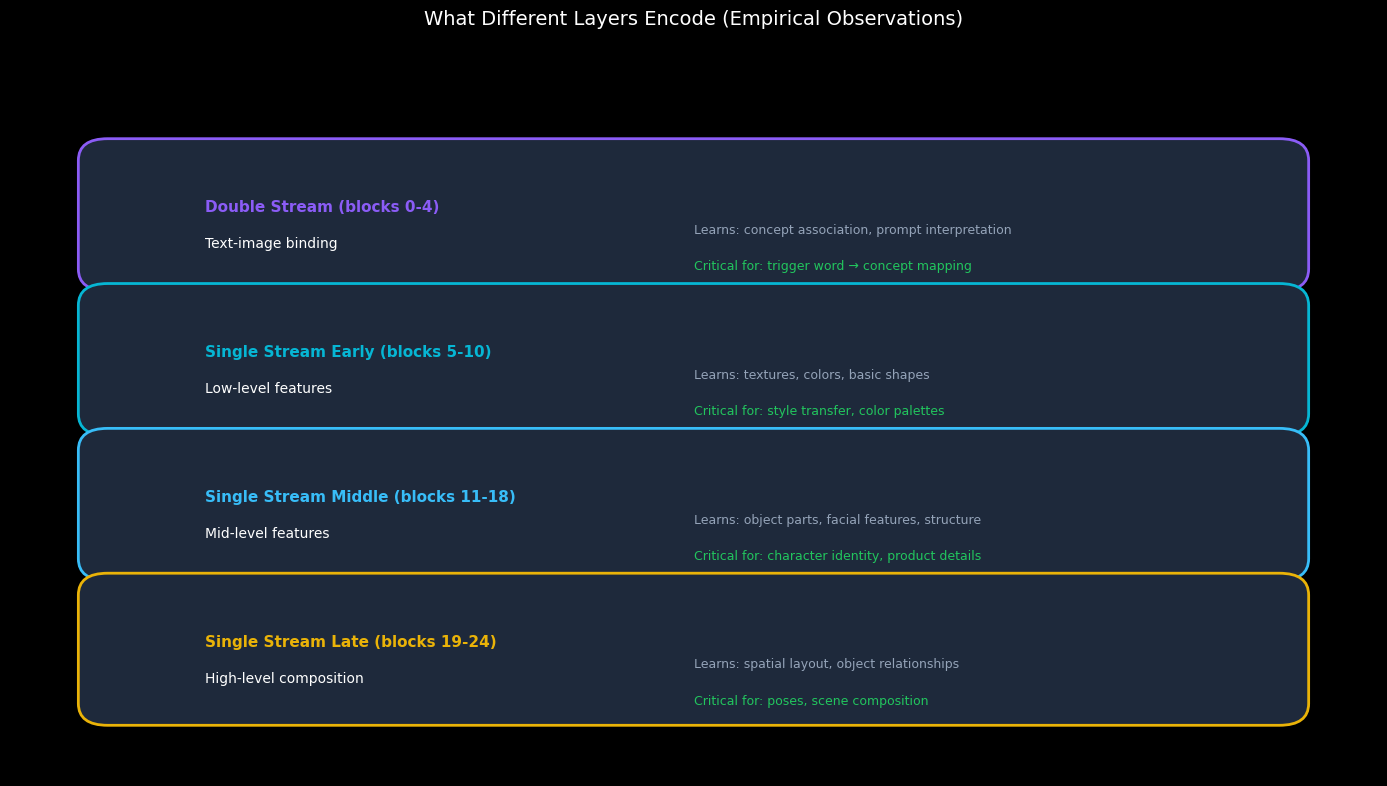

In [14]:
def show_layer_roles():
    """What different layers tend to learn."""
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.set_xlim(0, 14)
    ax.set_ylim(0, 10)
    ax.axis('off')
    ax.set_title('What Different Layers Encode (Empirical Observations)', fontsize=14, pad=20)
    
    # Y positions
    y_double = 7.5
    y_early = 5.5
    y_mid = 3.5
    y_late = 1.5
    
    # Double stream
    ax.add_patch(FancyBboxPatch((1, y_double - 0.5), 12, 1.5, boxstyle="round",
                                 facecolor='#1e293b', edgecolor=C['double'], linewidth=2))
    ax.text(2, y_double + 0.3, 'Double Stream (blocks 0-4)', fontsize=11, 
           fontweight='bold', color=C['double'])
    ax.text(2, y_double - 0.2, 'Text-image binding', fontsize=10, color='white')
    ax.text(7, y_double, 'Learns: concept association, prompt interpretation', 
           fontsize=9, color='#94a3b8')
    ax.text(7, y_double - 0.5, 'Critical for: trigger word → concept mapping', 
           fontsize=9, color=C['good'])
    
    # Single stream - early
    ax.add_patch(FancyBboxPatch((1, y_early - 0.5), 12, 1.5, boxstyle="round",
                                 facecolor='#1e293b', edgecolor=C['single'], linewidth=2))
    ax.text(2, y_early + 0.3, 'Single Stream Early (blocks 5-10)', fontsize=11, 
           fontweight='bold', color=C['single'])
    ax.text(2, y_early - 0.2, 'Low-level features', fontsize=10, color='white')
    ax.text(7, y_early, 'Learns: textures, colors, basic shapes', 
           fontsize=9, color='#94a3b8')
    ax.text(7, y_early - 0.5, 'Critical for: style transfer, color palettes', 
           fontsize=9, color=C['good'])
    
    # Single stream - middle  
    ax.add_patch(FancyBboxPatch((1, y_mid - 0.5), 12, 1.5, boxstyle="round",
                                 facecolor='#1e293b', edgecolor=C['info'], linewidth=2))
    ax.text(2, y_mid + 0.3, 'Single Stream Middle (blocks 11-18)', fontsize=11, 
           fontweight='bold', color=C['info'])
    ax.text(2, y_mid - 0.2, 'Mid-level features', fontsize=10, color='white')
    ax.text(7, y_mid, 'Learns: object parts, facial features, structure', 
           fontsize=9, color='#94a3b8')
    ax.text(7, y_mid - 0.5, 'Critical for: character identity, product details', 
           fontsize=9, color=C['good'])
    
    # Single stream - late
    ax.add_patch(FancyBboxPatch((1, y_late - 0.5), 12, 1.5, boxstyle="round",
                                 facecolor='#1e293b', edgecolor=C['warn'], linewidth=2))
    ax.text(2, y_late + 0.3, 'Single Stream Late (blocks 19-24)', fontsize=11, 
           fontweight='bold', color=C['warn'])
    ax.text(2, y_late - 0.2, 'High-level composition', fontsize=10, color='white')
    ax.text(7, y_late, 'Learns: spatial layout, object relationships', 
           fontsize=9, color='#94a3b8')
    ax.text(7, y_late - 0.5, 'Critical for: poses, scene composition', 
           fontsize=9, color=C['good'])
    
    plt.tight_layout()
    plt.show()

show_layer_roles()

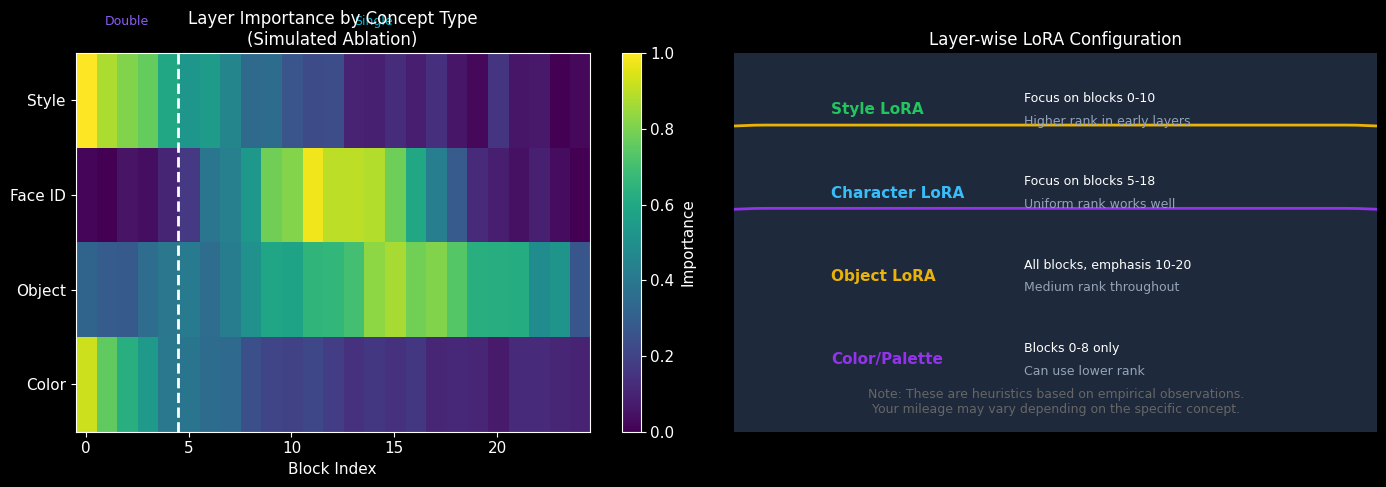

In [15]:
def simulate_layer_importance():
    """Simulated ablation study showing layer importance."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    np.random.seed(42)
    
    # === Left: Heatmap of layer importance ===
    ax1 = axes[0]
    
    # Simulated importance scores (what we might see from ablation)
    n_blocks = 25
    concepts = ['Style', 'Face ID', 'Object', 'Color']
    
    importance = np.zeros((len(concepts), n_blocks))
    
    # Style: early layers matter most
    importance[0, :] = np.exp(-np.arange(n_blocks) / 8) + np.random.randn(n_blocks) * 0.05
    
    # Face ID: middle layers matter most
    importance[1, :] = np.exp(-((np.arange(n_blocks) - 12)**2) / 30) + np.random.randn(n_blocks) * 0.05
    
    # Object: spread across, peak in middle-late
    importance[2, :] = 0.3 + 0.5 * np.exp(-((np.arange(n_blocks) - 15)**2) / 50) + np.random.randn(n_blocks) * 0.05
    
    # Color: early layers dominate
    importance[3, :] = 0.8 * np.exp(-np.arange(n_blocks) / 5) + 0.1 + np.random.randn(n_blocks) * 0.03
    
    importance = np.clip(importance, 0, 1)
    
    im = ax1.imshow(importance, aspect='auto', cmap='viridis')
    ax1.set_xlabel('Block Index')
    ax1.set_yticks(range(len(concepts)))
    ax1.set_yticklabels(concepts)
    ax1.set_title('Layer Importance by Concept Type\n(Simulated Ablation)', fontsize=12)
    
    # Mark double vs single stream
    ax1.axvline(x=4.5, color='white', linestyle='--', linewidth=2)
    ax1.text(2, -0.8, 'Double', ha='center', fontsize=9, color=C['double'])
    ax1.text(14, -0.8, 'Single', ha='center', fontsize=9, color=C['single'])
    
    plt.colorbar(im, ax=ax1, label='Importance')
    
    # === Right: Recommendations ===
    ax2 = axes[1]
    ax2.axis('off')
    ax2.set_title('Layer-wise LoRA Configuration', fontsize=12)
    
    recommendations = [
        ('Style LoRA', 'Focus on blocks 0-10', 'Higher rank in early layers', C['good']),
        ('Character LoRA', 'Focus on blocks 5-18', 'Uniform rank works well', C['info']),
        ('Object LoRA', 'All blocks, emphasis 10-20', 'Medium rank throughout', C['warn']),
        ('Color/Palette', 'Blocks 0-8 only', 'Can use lower rank', C['dora']),
    ]
    
    for i, (concept, layers, rank, color) in enumerate(recommendations):
        y = 0.85 - i * 0.22
        ax2.add_patch(FancyBboxPatch((0.05, y-0.08), 0.9, 0.18, boxstyle="round",
                                      facecolor='#1e293b', edgecolor=color, linewidth=2,
                                      transform=ax2.transAxes))
        ax2.text(0.15, y, concept, fontsize=11, fontweight='bold', color=color,
                transform=ax2.transAxes, va='center')
        ax2.text(0.45, y+0.03, layers, fontsize=9, color='white',
                transform=ax2.transAxes, va='center')
        ax2.text(0.45, y-0.03, rank, fontsize=9, color='#94a3b8',
                transform=ax2.transAxes, va='center')
    
    ax2.text(0.5, 0.05, 'Note: These are heuristics based on empirical observations.\n'
            'Your mileage may vary depending on the specific concept.',
            ha='center', fontsize=9, color='#666', transform=ax2.transAxes)
    
    plt.tight_layout()
    plt.show()

simulate_layer_importance()

---
# Part 5: LoRA Composition and Merging

One of LoRA's killer features: you can combine multiple LoRAs at inference time.

But this has caveats.

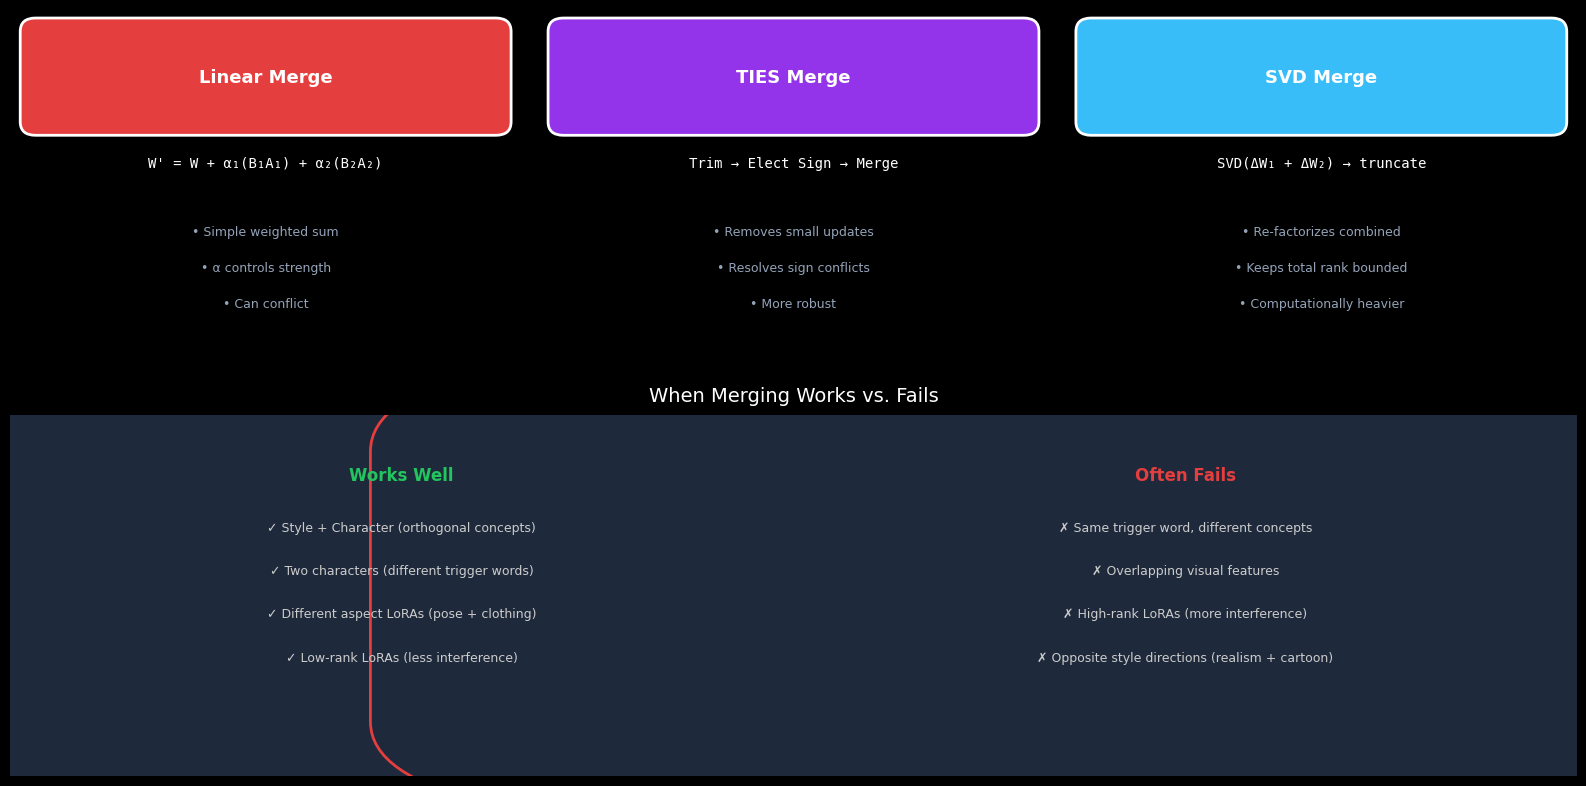

In [16]:
def explain_lora_merging():
    """How LoRA merging works and when it fails."""
    fig = plt.figure(figsize=(16, 8))
    gs = GridSpec(2, 3, figure=fig)
    
    # === Top row: Methods ===
    methods = [
        ('Linear Merge', 
         'W\' = W + α₁(B₁A₁) + α₂(B₂A₂)',
         ['Simple weighted sum', 'α controls strength', 'Can conflict'],
         C['lora']),
        ('TIES Merge',
         'Trim → Elect Sign → Merge',
         ['Removes small updates', 'Resolves sign conflicts', 'More robust'],
         C['dora']),
        ('SVD Merge',
         'SVD(ΔW₁ + ΔW₂) → truncate',
         ['Re-factorizes combined', 'Keeps total rank bounded', 'Computationally heavier'],
         C['info']),
    ]
    
    for i, (name, formula, points, color) in enumerate(methods):
        ax = fig.add_subplot(gs[0, i])
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 8)
        ax.axis('off')
        
        ax.add_patch(FancyBboxPatch((0.5, 5.5), 9, 2, boxstyle="round",
                                     facecolor=color, edgecolor='white', linewidth=2))
        ax.text(5, 6.5, name, ha='center', va='center', fontsize=13, 
               fontweight='bold', color='white')
        
        ax.text(5, 4.5, formula, ha='center', fontsize=10, family='monospace', color='white')
        
        for j, point in enumerate(points):
            ax.text(5, 3 - j*0.8, f'• {point}', ha='center', fontsize=9, color='#94a3b8')
    
    # === Bottom: When merging fails ===
    ax_bottom = fig.add_subplot(gs[1, :])
    ax_bottom.axis('off')
    ax_bottom.set_title('When Merging Works vs. Fails', fontsize=14, pad=10)
    
    # Works well
    ax_bottom.add_patch(FancyBboxPatch((0.02, 0.15), 0.45, 0.75, boxstyle="round",
                                        facecolor='#1e293b', edgecolor=C['good'], linewidth=2,
                                        transform=ax_bottom.transAxes))
    ax_bottom.text(0.25, 0.82, 'Works Well', ha='center', fontsize=12, fontweight='bold',
                  color=C['good'], transform=ax_bottom.transAxes)
    
    works = [
        'Style + Character (orthogonal concepts)',
        'Two characters (different trigger words)', 
        'Different aspect LoRAs (pose + clothing)',
        'Low-rank LoRAs (less interference)',
    ]
    for j, w in enumerate(works):
        ax_bottom.text(0.25, 0.68 - j*0.12, f'✓ {w}', ha='center', fontsize=9,
                      color='#ccc', transform=ax_bottom.transAxes)
    
    # Fails
    ax_bottom.add_patch(FancyBboxPatch((0.53, 0.15), 0.45, 0.75, boxstyle="round",
                                        facecolor='#1e293b', edgecolor=C['lora'], linewidth=2,
                                        transform=ax_bottom.transAxes))
    ax_bottom.text(0.75, 0.82, 'Often Fails', ha='center', fontsize=12, fontweight='bold',
                  color=C['lora'], transform=ax_bottom.transAxes)
    
    fails = [
        'Same trigger word, different concepts',
        'Overlapping visual features',
        'High-rank LoRAs (more interference)',
        'Opposite style directions (realism + cartoon)',
    ]
    for j, f in enumerate(fails):
        ax_bottom.text(0.75, 0.68 - j*0.12, f'✗ {f}', ha='center', fontsize=9,
                      color='#ccc', transform=ax_bottom.transAxes)
    
    plt.tight_layout()
    plt.show()

explain_lora_merging()

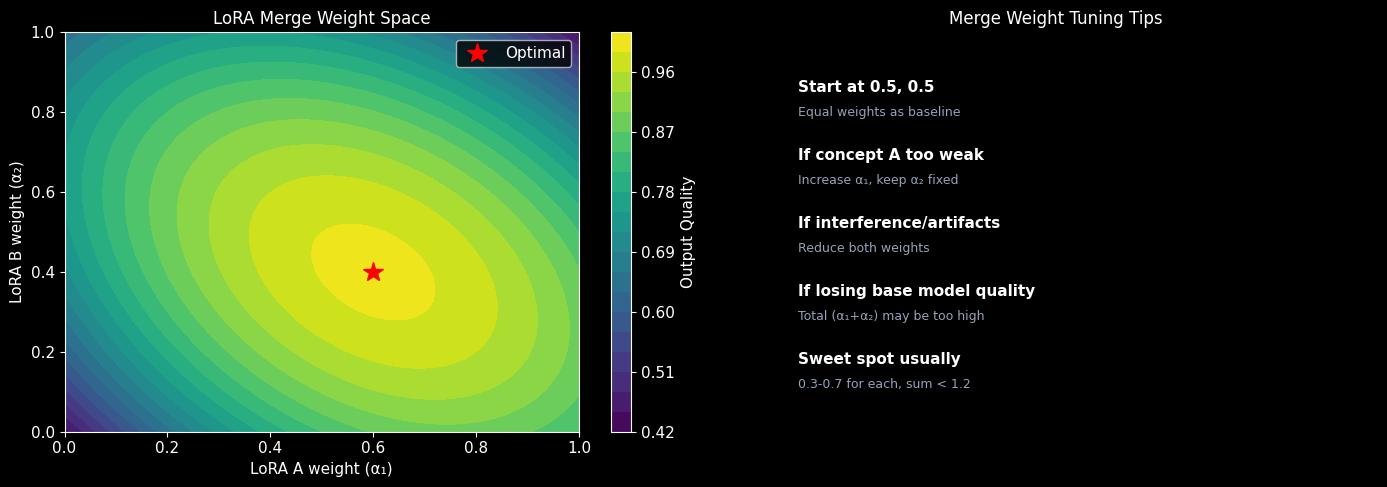

In [17]:
def show_merge_weight_tuning():
    """Visualize how merge weights affect output."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # === Left: Weight space ===
    ax1 = axes[0]
    ax1.set_title('LoRA Merge Weight Space', fontsize=12)
    
    # Create a simple 2D visualization
    alpha1 = np.linspace(0, 1, 50)
    alpha2 = np.linspace(0, 1, 50)
    A1, A2 = np.meshgrid(alpha1, alpha2)
    
    # Simulated quality metric (peaks when balanced, drops at extremes)
    quality = 1 - 0.5 * ((A1 - 0.6)**2 + (A2 - 0.4)**2) - 0.3 * (A1 + A2 - 1)**2
    quality = np.clip(quality, 0, 1)
    
    im = ax1.contourf(A1, A2, quality, levels=20, cmap='viridis')
    ax1.set_xlabel('LoRA A weight (α₁)')
    ax1.set_ylabel('LoRA B weight (α₂)')
    plt.colorbar(im, ax=ax1, label='Output Quality')
    
    # Mark optimal region
    ax1.plot(0.6, 0.4, 'r*', markersize=15, label='Optimal')
    ax1.legend()
    
    # === Right: Practical guidance ===
    ax2 = axes[1]
    ax2.axis('off')
    ax2.set_title('Merge Weight Tuning Tips', fontsize=12)
    
    tips = [
        ('Start at 0.5, 0.5', 'Equal weights as baseline'),
        ('If concept A too weak', 'Increase α₁, keep α₂ fixed'),
        ('If interference/artifacts', 'Reduce both weights'),
        ('If losing base model quality', 'Total (α₁+α₂) may be too high'),
        ('Sweet spot usually', '0.3-0.7 for each, sum < 1.2'),
    ]
    
    for i, (tip, detail) in enumerate(tips):
        y = 0.85 - i * 0.17
        ax2.text(0.1, y, tip, fontsize=11, fontweight='bold', color='white',
                transform=ax2.transAxes)
        ax2.text(0.1, y - 0.06, detail, fontsize=9, color='#94a3b8',
                transform=ax2.transAxes)
    
    plt.tight_layout()
    plt.show()

show_merge_weight_tuning()

---
# Part 6: Text Encoder vs Transformer Fine-tuning

You can also apply LoRA to the text encoder (Qwen3 in Klein Base). When should you?

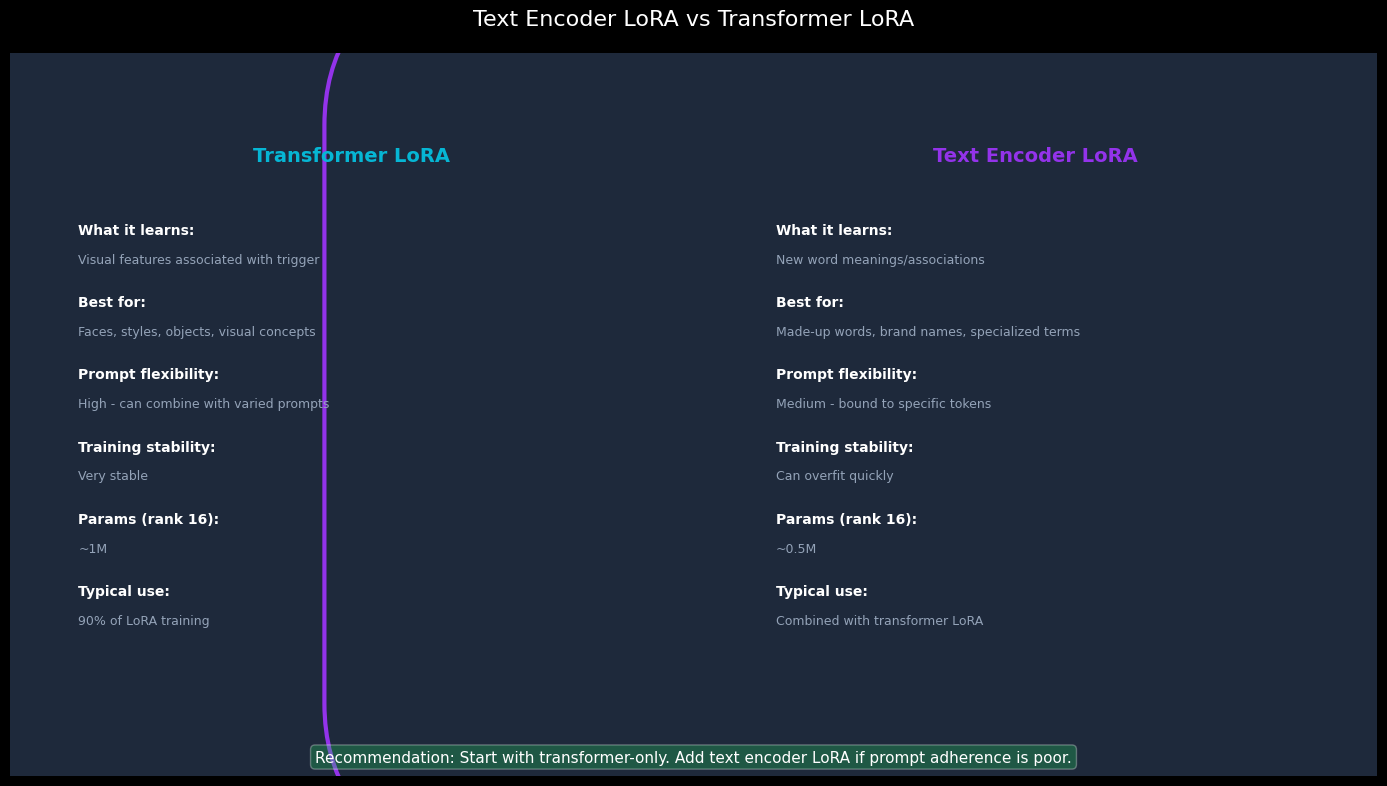

In [18]:
def compare_text_encoder_finetuning():
    """When to fine-tune text encoder vs transformer."""
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.axis('off')
    ax.set_title('Text Encoder LoRA vs Transformer LoRA', fontsize=16, pad=20)
    
    # Create two columns
    # Transformer LoRA (left)
    ax.add_patch(FancyBboxPatch((0.02, 0.1), 0.45, 0.8, boxstyle="round",
                                 facecolor='#1e293b', edgecolor=C['single'], linewidth=3,
                                 transform=ax.transAxes))
    ax.text(0.25, 0.85, 'Transformer LoRA', ha='center', fontsize=14, 
           fontweight='bold', color=C['single'], transform=ax.transAxes)
    
    transformer_points = [
        ('What it learns', 'Visual features associated with trigger'),
        ('Best for', 'Faces, styles, objects, visual concepts'),
        ('Prompt flexibility', 'High - can combine with varied prompts'),
        ('Training stability', 'Very stable'),
        ('Params (rank 16)', '~1M'),
        ('Typical use', '90% of LoRA training'),
    ]
    
    for i, (label, value) in enumerate(transformer_points):
        y = 0.75 - i * 0.1
        ax.text(0.05, y, label + ':', fontsize=10, fontweight='bold', color='white',
               transform=ax.transAxes)
        ax.text(0.05, y - 0.04, value, fontsize=9, color='#94a3b8',
               transform=ax.transAxes)
    
    # Text Encoder LoRA (right)
    ax.add_patch(FancyBboxPatch((0.53, 0.1), 0.45, 0.8, boxstyle="round",
                                 facecolor='#1e293b', edgecolor=C['dora'], linewidth=3,
                                 transform=ax.transAxes))
    ax.text(0.75, 0.85, 'Text Encoder LoRA', ha='center', fontsize=14, 
           fontweight='bold', color=C['dora'], transform=ax.transAxes)
    
    text_encoder_points = [
        ('What it learns', 'New word meanings/associations'),
        ('Best for', 'Made-up words, brand names, specialized terms'),
        ('Prompt flexibility', 'Medium - bound to specific tokens'),
        ('Training stability', 'Can overfit quickly'),
        ('Params (rank 16)', '~0.5M'),
        ('Typical use', 'Combined with transformer LoRA'),
    ]
    
    for i, (label, value) in enumerate(text_encoder_points):
        y = 0.75 - i * 0.1
        ax.text(0.56, y, label + ':', fontsize=10, fontweight='bold', color='white',
               transform=ax.transAxes)
        ax.text(0.56, y - 0.04, value, fontsize=9, color='#94a3b8',
               transform=ax.transAxes)
    
    # Bottom recommendation
    ax.text(0.5, 0.02, 
           'Recommendation: Start with transformer-only. Add text encoder LoRA if prompt adherence is poor.',
           ha='center', fontsize=11, color='white', transform=ax.transAxes,
           bbox=dict(boxstyle='round', facecolor=C['good'], alpha=0.3))
    
    plt.tight_layout()
    plt.show()

compare_text_encoder_finetuning()

---
# Part 7: Training Configuration Reference

Bringing it all together with concrete configurations.

In [19]:
def show_config_templates():
    """Ready-to-use configuration templates."""
    
    configs = {
        'style_transfer': {
            'description': 'Artistic style, color palette, texture',
            'rank': 16,
            'alpha': 16,
            'lr': '3e-4',
            'steps': '500-800',
            'targets': 'transformer attention only',
            'data': '50-200 images',
            'notes': 'Focus on early/mid blocks. Can use lower rank (8-16).'
        },
        'character_face': {
            'description': 'Person identity, face, consistent character',
            'rank': 32,
            'alpha': 32,
            'lr': '2e-4',
            'steps': '800-1200',
            'targets': 'transformer attention + optional text encoder',
            'data': '20-50 high-quality images',
            'notes': 'Diverse poses/expressions critical. Watch for overfitting.'
        },
        'object_product': {
            'description': 'Specific object, product, item',
            'rank': 24,
            'alpha': 24,
            'lr': '2e-4',
            'steps': '600-1000',
            'targets': 'transformer attention',
            'data': '30-100 images, varied angles',
            'notes': 'Include context variation. Describe object details in captions.'
        },
        'complex_concept': {
            'description': 'Multi-aspect concept, scene type, interaction',
            'rank': 48,
            'alpha': 48,
            'lr': '1e-4',
            'steps': '1000-1500',
            'targets': 'transformer attention + MLP',
            'data': '50-150 images',
            'notes': 'Consider DoRA. May need longer training. Regularization helps.'
        }
    }
    
    print("="*70)
    print("KLEIN BASE 4B - LORA CONFIGURATION TEMPLATES")
    print("="*70)
    
    for name, cfg in configs.items():
        print(f"\n{'─'*70}")
        print(f"  {name.upper().replace('_', ' ')}")
        print(f"  {cfg['description']}")
        print(f"{'─'*70}")
        print(f"  Rank:           {cfg['rank']}")
        print(f"  Alpha:          {cfg['alpha']}")
        print(f"  Learning Rate:  {cfg['lr']}")
        print(f"  Steps:          {cfg['steps']}")
        print(f"  LoRA Targets:   {cfg['targets']}")
        print(f"  Data:           {cfg['data']}")
        print(f"  Notes:          {cfg['notes']}")
    
    print("\n" + "="*70)
    print("UNIVERSAL SETTINGS")
    print("="*70)
    print("  Optimizer:      AdamW (or Prodigy for auto-LR)")
    print("  Scheduler:      Cosine with warmup (10% steps)")
    print("  Batch size:     1-4 (gradient accumulation if needed)")
    print("  Mixed precision: bf16 (Klein Base native)")
    print("  Guidance:       4.0 during training")
    print("="*70)

show_config_templates()

KLEIN BASE 4B - LORA CONFIGURATION TEMPLATES

──────────────────────────────────────────────────────────────────────
  STYLE TRANSFER
  Artistic style, color palette, texture
──────────────────────────────────────────────────────────────────────
  Rank:           16
  Alpha:          16
  Learning Rate:  3e-4
  Steps:          500-800
  LoRA Targets:   transformer attention only
  Data:           50-200 images
  Notes:          Focus on early/mid blocks. Can use lower rank (8-16).

──────────────────────────────────────────────────────────────────────
  CHARACTER FACE
  Person identity, face, consistent character
──────────────────────────────────────────────────────────────────────
  Rank:           32
  Alpha:          32
  Learning Rate:  2e-4
  Steps:          800-1200
  LoRA Targets:   transformer attention + optional text encoder
  Data:           20-50 high-quality images
  Notes:          Diverse poses/expressions critical. Watch for overfitting.

──────────────────────────────

---

# Summary

**Key takeaways:**

1. **Flow matching changes the game** — Klein Base's continuous timesteps and velocity prediction mean more stable training without SNR weighting hacks

2. **Architecture matters** — Double-stream blocks handle text↔image binding, single-stream handles visual features. Target accordingly.

3. **Beyond vanilla LoRA** — DoRA often gives better text alignment; LoKr uses fewer parameters; full fine-tuning is still best if you have compute

4. **Layers encode different things** — Early layers → style/color, middle → features/identity, late → composition. Layer-wise rank can help.

5. **Merging works when concepts are orthogonal** — Different triggers, different aspects. Fails when concepts conflict.

6. **Text encoder LoRA is optional** — Only add if prompt adherence is weak

---

*Workshop materials for Black Forest Labs*